# Autograd

In [1]:
import torch

## Autograd

tensor 그냥은 require_grad가 False인데

In [4]:
x = torch.ones(1)
x.requires_grad # False
y = torch.ones(1)
y.requires_grad#False
z = x+y 
z.requires_grad #False

False

In [5]:
x.requires_grad_()
x.requires_grad

True

이렇게 True로 바꿔줄 수 있고, True로 바꿔주면 걔를 이용한 연산을 해도 requires grad = True가 나온다.

In [7]:
z = x + y
z.requires_grad 

True

In [8]:
y = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
y

tensor([[1., 2.],
        [3., 4.]])

In [10]:
y.requires_grad

False

In [11]:
y = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32, requires_grad=True)
y

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

이렇게 requires_grad True로 설정을 해주면, y.sum()이나 y.max를 하면 backward를 알아서 해준다.

In [12]:
y.sum()

tensor(10., grad_fn=<SumBackward0>)

backward가 자동으로 sum에 대한 backward라고 설정이 되고, 

In [17]:
z = 2*y +1
z # auto grad는 맨 마지막에 있는 것에 대한 grad, 여기서는 +가 마지막에 있어서 

tensor([[3., 5.],
        [7., 9.]], grad_fn=<AddBackward0>)

In [14]:
z.grad_fn.next_functions#next_function을 통해 다음 backward를 파악할 수 있음. + 다음에 곱하기 하니까

((<MulBackward0 at 0x7fcdd14a20d0>, 0), (None, 0))

In [18]:
out = z.sum()
out.backward() #z는 행렬이라 backward 안됨, backward는 scalar output만

In [23]:
print(y.grad)
print(z.grad)
print(out.grad) # 메모리 때문에 grad function 없는 마지막에 선언한것만 저장
print("y.grad_fn :", y.grad_fn)
print("z.grad_fn :", z.grad_fn)
print("out.grad_fn :", out.grad_fn)

tensor([[4., 4.],
        [4., 4.]])
None
None
y.grad_fn : None
z.grad_fn : <AddBackward0 object at 0x7fcdd14e9950>
out.grad_fn : <SumBackward0 object at 0x7fcdd14e9d10>


/home/tako/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  
/home/tako/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  Thi

tensor을 numpy로 바꾸고 싶을때,
z.numpy를 하면 z에는 grad 등이 저장되어 있기 때문에 바로 변환할 수 없음.
따라서, z.detach().numpy() 혹은 z.data().numpy()를 사용함.

In [27]:
z.detach().numpy() 

array([[3., 5.],
       [7., 9.]], dtype=float32)

In [39]:
a = torch.tensor([1,2,3.], requires_grad = True)
b = a.exp()
print(b)
# c는 b를 graph에서 떼어내어 require gradient = False
# 허나, 원본 데이터는 공유
c = b.detach()
c.zero_()
print(c)
print(b)# b도 초기화가 됨.
#여기서 b.sum().backward()을 하면 b가 초기화 되었기 때문에 에러가 남

tensor([ 2.7183,  7.3891, 20.0855], grad_fn=<ExpBackward>)
tensor([0., 0., 0.])
tensor([0., 0., 0.], grad_fn=<ExpBackward>)


In [42]:
print(a.grad)# backward가 안되었기 때문에

None


In [46]:
a = torch.tensor([1,2,3.], requires_grad = True)
b = a.exp()
print(b)

# 허나, 원본 데이터는 공유
c = b.data
c.zero_()
print(c)
print(b)# b도 초기화가 됨.

tensor([ 2.7183,  7.3891, 20.0855], grad_fn=<ExpBackward>)
tensor([0., 0., 0.])
tensor([0., 0., 0.], grad_fn=<ExpBackward>)


In [47]:
b.sum().backward() #data는 grad에 영향을 주지 않기 때문에 inplace가 일어나도 에러가 뜨지 않음.
a.grad#따라서 잘못된 결과가 나왔음.

tensor([0., 0., 0.])

# Linear model


## 선형회귀와 신경망
1. Forward 단계.
데이터 처리 -> 모델 구현 -> 예측값 도출 -> loss function 계산
2. Backward.
기울기 계산 -> 개선 방향 찾기 -> 가중치 개선(w를 바꿔줌)

- 신경망은 input layer, hidden layer, output layer로 구성되어 있다.
- 선형신경망에서, hidden layer의 개수를 늘려도 선형결합이기 때문에 layer를 하나만 사용한 것과 같은 효과가 나온다.
- 이를 방지하기 위해 activation function을 추가해 선형성을 깨트릴 수 있도록 한다.

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

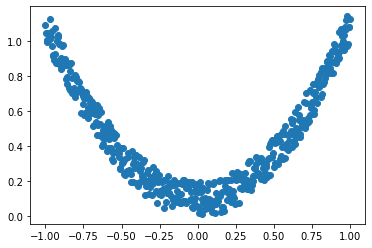

In [67]:
x = torch.linspace(-1, 1, 500)
y = x.pow(2) + 0.2*torch.rand(x.size())

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [68]:
x.shape, y.shape

(torch.Size([500]), torch.Size([500]))

In [69]:
x = torch.unsqueeze(x, dim=1) # reshape와 같음.
y = torch.unsqueeze(y, dim=1)

In [70]:
x.shape, y.shape

(torch.Size([500, 1]), torch.Size([500, 1]))

In [71]:
hidden = nn.Linear(1, 20, bias=True)#20+20
output = nn.Linear(20, 1, bias=True)#21

In [72]:
model = nn.Sequential(hidden, output)

In [73]:
loss = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

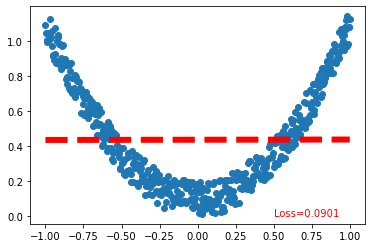

In [74]:
for step in range(500):
    pre = model(x)
    cost = loss(pre, y)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
plt.scatter(x.data.numpy(), y.data.numpy())
plt.plot(x.data.numpy(), pre.data.numpy(), 'r--', lw=6)
plt.text(0.5, 0, 'Loss=%.4f' % cost.item(), fontdict={'size':10, 'color':'red'}) 
# linear 모델은 linear밖에 예측할 수 없음, hidden layer 개수를 증가시켜도 linear 하나 사용한것과 같음.
plt.show()

In [79]:
hidden = nn.Linear(1, 20, bias=True)
activation = nn.ReLU() #따라서, activation fuction을 넣어줘 선형성을 깨트림.
output = nn.Linear(20, 1, bias=True)

In [80]:
model = nn.Sequential(hidden, activation, output) 

In [83]:
loss = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

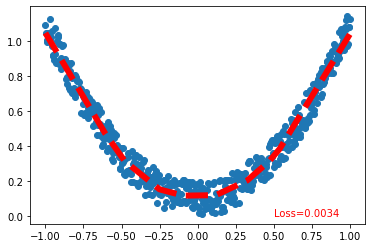

In [85]:
for step in range(500):
    pre = model(x)
    cost = loss(pre, y)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
plt.scatter(x.data.numpy(), y.data.numpy())
plt.plot(x.data.numpy(), pre.data.numpy(), 'r--', lw=6)
plt.text(0.5, 0, 'Loss=%.4f' % cost.item(), fontdict={'size':10, 'color':'red'})
plt.show()